In [20]:
import sys
import os

# Ajoute le dossier parent au chemin
os.chdir("C:/Users/Elliot/OneDrive/Bureau/hft-rl-latency-aware-arbitrage")


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.real_hft_env import RealHFTEnv
from stable_baselines3 import PPO
import os
import matplotlib.animation as animation

In [27]:
file = "data/ethusdt_ticks.csv"
df = pd.read_csv(file)
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")
df.head()

,timestamp,price,quantity,side
0,2025-06-27 15:17:35.498,2435.39,0.0086,buy
1,2025-06-27 15:17:35.498,2435.39,0.0050,buy
2,2025-06-27 15:17:35.498,2435.39,0.0180,buy
3,2025-06-27 15:17:35.498,2435.39,0.0022,buy
4,2025-06-27 15:17:35.498,2435.39,0.0006,buy


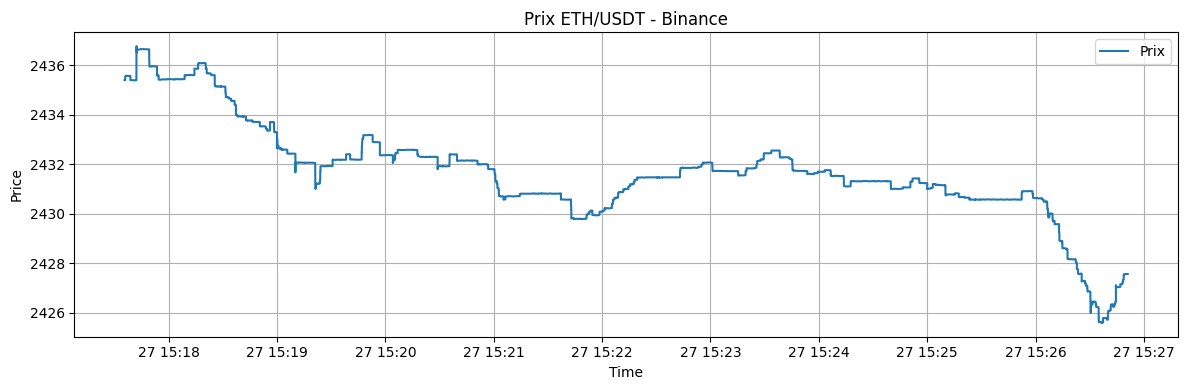

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(df["timestamp"], df["price"], label="Prix")
plt.title("Prix ETH/USDT - Binance")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid()
plt.legend()
plt.tight_layout()
os.makedirs("results/plots", exist_ok=True)
plt.savefig("results/plots/price_evolution.png")
plt.show()

In [29]:
env = RealHFTEnv(csv_path=file, max_steps=500)
obs, _ = env.reset()

rewards_random, prices, inventory_random, cash_random = [], [], [], []

done = False
while not done:
    action = np.random.choice([0, 1, 2])
    obs, reward, done, _, info = env.step(action)
    rewards_random.append(reward)
    prices.append(info["price"])
    inventory_random.append(info["inventory"])
    cash_random.append(info["cash"])

c:\Users\Elliot\anaconda3\envs\Test\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\Elliot\anaconda3\envs\Test\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [30]:
env = RealHFTEnv(csv_path=file, max_steps=500)
obs, _ = env.reset()

rewards_bh, inventory_bh, cash_bh = [], [], []
done = False
first_action_done = False

while not done:
    if not first_action_done:
        action = 1  # Buy
        first_action_done = True
    else:
        action = 0  # Hold
    obs, reward, done, _, info = env.step(action)
    rewards_bh.append(reward)
    inventory_bh.append(info["inventory"])
    cash_bh.append(info["cash"])

c:\Users\Elliot\anaconda3\envs\Test\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\Elliot\anaconda3\envs\Test\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [31]:
model_path = "results/checkpoints/ppo_real_env_model"
model = PPO.load(model_path)

env = RealHFTEnv(csv_path=file, max_steps=500)
obs, _ = env.reset()

rewards_ppo, inventory_ppo, cash_ppo, price_ppo = [], [], [], []
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    rewards_ppo.append(reward)
    inventory_ppo.append(info["inventory"])
    cash_ppo.append(info["cash"])
    price_ppo.append(info["price"])

c:\Users\Elliot\anaconda3\envs\Test\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
c:\Users\Elliot\anaconda3\envs\Test\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\Elliot\anaconda3\envs\Test\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [32]:
log_df = pd.DataFrame({
    "step": list(range(len(rewards_ppo))),
    "price": price_ppo,
    "reward": rewards_ppo,
    "inventory": inventory_ppo,
    "cash": cash_ppo
})
os.makedirs("results/logs", exist_ok=True)
log_df.to_csv("results/logs/ppo_run_log.csv", index=False)

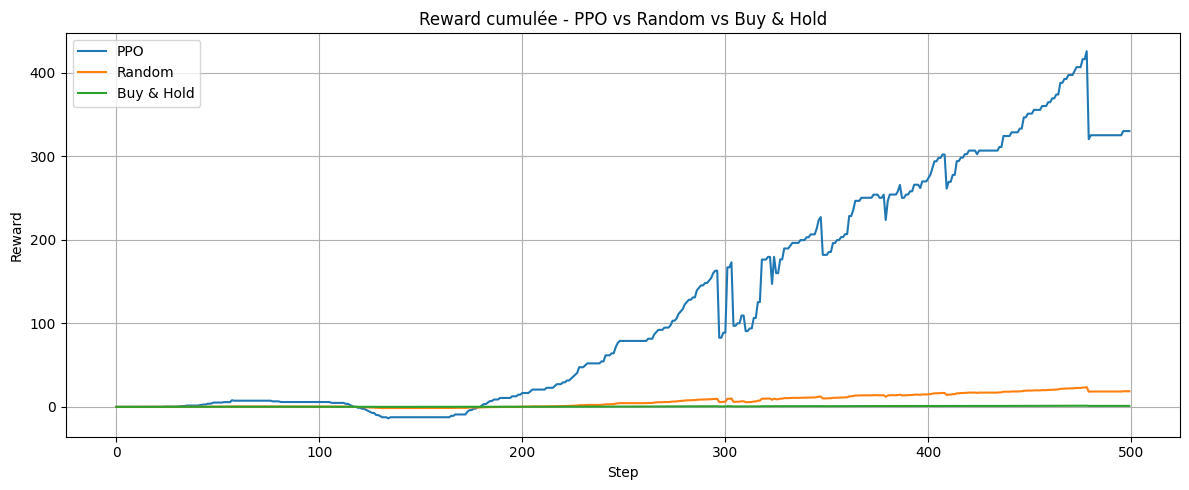

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(rewards_ppo, label="PPO")
plt.plot(rewards_random, label="Random")
plt.plot(rewards_bh, label="Buy & Hold")
plt.title("Reward cumulée - PPO vs Random vs Buy & Hold")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("results/plots/reward_comparison.png")
plt.show()

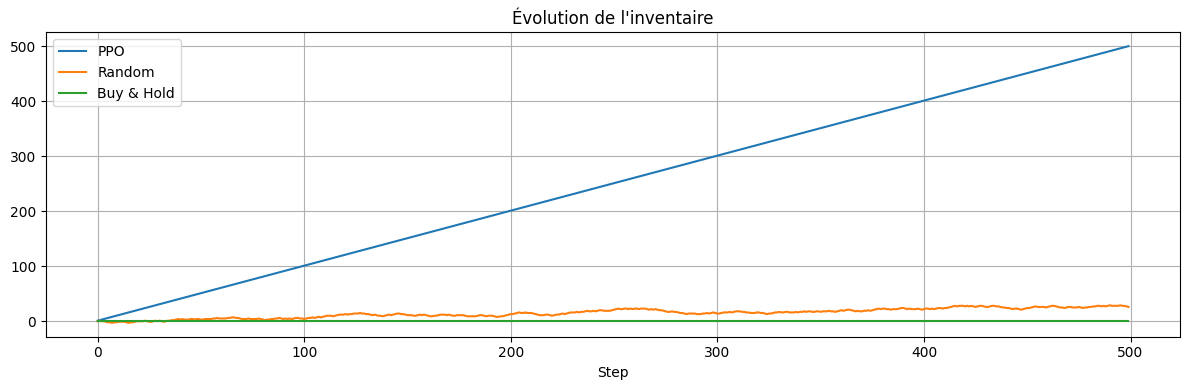

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(inventory_ppo, label="PPO")
plt.plot(inventory_random, label="Random")
plt.plot(inventory_bh, label="Buy & Hold")
plt.title("Évolution de l'inventaire")
plt.xlabel("Step")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("results/plots/inventory_comparison.png")
plt.show()

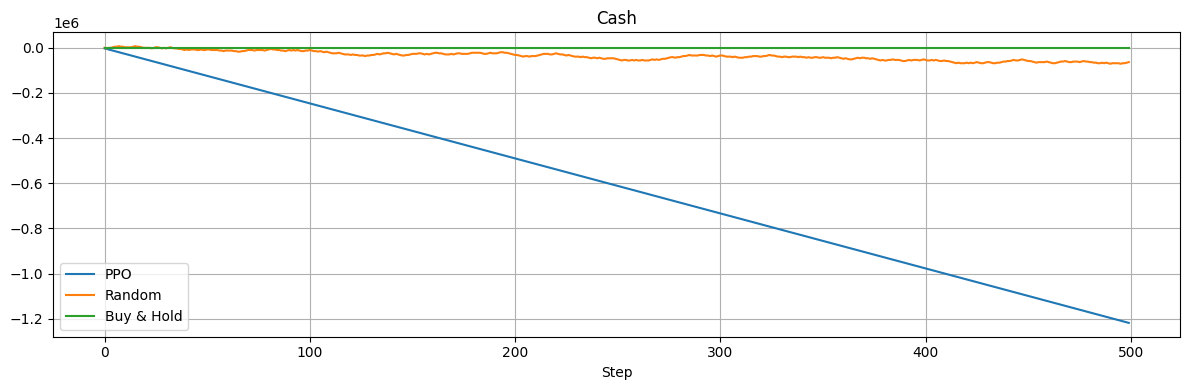

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(cash_ppo, label="PPO")
plt.plot(cash_random, label="Random")
plt.plot(cash_bh, label="Buy & Hold")
plt.title("Cash")
plt.xlabel("Step")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("results/plots/cash_comparison.png")
plt.show()

In [36]:
fig, ax = plt.subplots(figsize=(10, 4))
line1, = ax.plot([], [], label="Prix")
line2, = ax.plot([], [], label="Inventaire")

ax.set_xlim(0, len(price_ppo))
ax.set_ylim(min(price_ppo) * 0.95, max(price_ppo) * 1.05)
ax.set_title("Évolution Prix vs Inventaire (PPO)")
ax.set_xlabel("Step")
ax.grid()
ax.legend()

x_data, y_price, y_inventory = [], [], []


def update(frame):
    x_data.append(frame)
    y_price.append(price_ppo[frame])
    y_inventory.append(inventory_ppo[frame])

    line1.set_data(x_data, y_price)
    line2.set_data(x_data, y_inventory)
    return line1, line2

ani = animation.FuncAnimation(fig, update, frames=len(price_ppo), blit=True, interval=30)
os.makedirs("results/animations", exist_ok=True)
ani.save("results/animations/ppo_price_inventory.gif", writer="pillow")
plt.close(fig)
